# Transit and settlements

This notebook assumes you have run the previous notebooks to generate, clean and explore data.

## Preamble

In [1]:
import os
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx
import contextily as cx
import matplotlib.pyplot as plt
import os
import libpysal as ps
import pointpats
import folium
import esda
import seaborn as sns
import esda



from pysal.lib import weights
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)

from pointpats import distance_statistics, PoissonPointProcess, Window, PointPattern
from splot.libpysal import plot_spatial_weights
from pointpats.distance_statistics import K, F, G, L
from shapely.geometry import Polygon, Point
from shapely.prepared import prep
from os.path import join
from libpysal.cg import shapely_ext
from scipy.spatial import Voronoi

In [2]:
dir_data = "data"
dir_pt = "public_transit"
dir_geopt = "rejseplanen-dk-geojson"
dir_gtfs = "improved-gtfs-rejseplanen-dk"
dir_clean = "cleaned"

fp_trains = "inspire-jernbane.gpkg"
fp_indbyggertal= "indbyggertal.csv"

In [3]:
stops = gpd.read_file(join(dir_data, dir_clean, "stops.gpkg"))
settlements = gpd.read_file(join(dir_data, dir_clean, "settlements.gpkg"))
municipalities = gpd.read_file(join(dir_data, dir_clean, "municipalities.gpkg"))
stops.sindex
settlements.sindex
municipalities.sindex;

## Assigning stops to settlements

In [4]:
# Adapted from: https://readmedium.com/voronoi-grids-a-practical-application-7e6ee3b1daf0
# Create a Voronoi diagram using the GeoDataFrame.
# Use -1 to check for and exclude regions that extend to infinity:
points = np.column_stack((stops.geometry.x, stops.geometry.y))
vor = Voronoi(points)
voronoi_polygons = [Polygon(vor.vertices[region]) 
                    for region in vor.regions 
                    if region and -1 not in region]

# Create a GeoDataFrame with the Voronoi polygons:
gdf_voronoi = gpd.GeoDataFrame(geometry=voronoi_polygons, 
                               crs=stops.crs)

minx, miny, maxx, maxy = municipalities.unary_union.bounds

bounding_box = Polygon.from_bounds(minx, miny, maxx, maxy)
print(bounding_box)

POLYGON ((441511.4799999999 6049785.41, 441511.4799999999 6402306.839999999, 893021.81 6402306.839999999, 893021.81 6049785.41, 441511.4799999999 6049785.41))


In [5]:
stops

,stop_id,stop_name,geometry
0,102785-000461011300,Dyrupgårds Alle (Odense Kommune),POINT (585275.942 6135110.911)
1,102785-000008600718,Vipperød St.,POINT (672250.020 6172400.001)
2,102785-000008600719,Holbæk St.,POINT (670143.976 6177768.015)
3,102785-000008600716,Hvalsø St.,POINT (680191.994 6164777.033)
4,102785-000008600717,Tølløse St.,POINT (674638.010 6166374.048)
...,...,...,...
36976,102785-000787329209,Navn mangler,POINT (461863.963 6289233.955)
36977,102785-000785001451,Navn mangler,POINT (458326.955 6292439.893)
36978,102785-000843200901,Terndrup Industri (Hadsundvej),POINT (564551.978 6296227.993)
36979,102785-000851141601,Fjellerad (Hadsund Landevej),POINT (562513.996 6309453.952)


In [6]:
x = stops.sjoin_nearest(settlements, distance_col='dist', max_distance=1000)[['stop_id','stop_name','geometry','name','dist']]
y = stops.sjoin_nearest(settlements, distance_col='dist', max_distance=1)[['stop_id','stop_name','geometry','name','dist']]

In [7]:
groupedx = x.groupby('name')
groupedy = y.groupby('name')

In [8]:
numstopsx = groupedx.agg({'stop_id': 'count'})
numstopsy = groupedy.agg({'stop_id': 'count'})

sx = settlements.join(numstopsx, on='name')
sx = sx.fillna({'stop_id': 0})
sx = sx.rename(columns={'stop_id': 'nearby_stops'})
sx = sx.join(numstopsy, on='name')
sx = sx.fillna({'stop_id': 0})
sx = sx.rename(columns={'stop_id': 'stops_contained'})
sx['stop_density'] = sx['stops_contained'] / sx['area']
sx[sx['stops_contained'] != sx['nearby_stops']].sample(2)

,type,id,name,code,population,households,density,area,geometry,nearby_stops,stops_contained,stop_density
7232,town,12337669-ae79-6b98-e053-d480220a5a3f,Porskær,17925,5,2,1374.937758,0.003637,MULTIPOLYGON Z (((519344.800 6092352.640 0.000...,1.0,0.0,0.000000
2689,town,12337669-c632-6b98-e053-d480220a5a3f,Dyngby,16477,63,29,650.709156,0.096817,MULTIPOLYGON Z (((577525.970 6201743.610 0.000...,2.0,1.0,10.328717


In [9]:
sx['area'].describe()

count    8038.000000
mean        0.428997
std         2.421661
min         0.002042
25%         0.028069
50%         0.069950
75%         0.194728
max        98.739492
Name: area, dtype: float64

There are a few outliers.

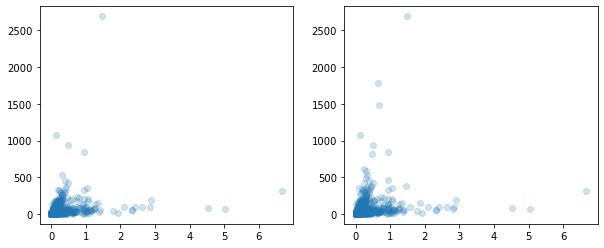

In [10]:
nonnear = sx[sx['nearby_stops'] == 0].copy()
nostops = sx[sx['stops_contained'] == 0].copy()
f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.scatter(nonnear['area'], nonnear['population'], alpha=0.2)
ax2.scatter(nostops['area'], nostops['population'], alpha=0.2)

In [11]:
nostops.iloc[nostops['area'].idxmax()]

/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/opt/conda/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/opt/conda/lib/python3.9/site-packages/pandas/io/formats/printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
/opt/conda/lib/python3.9/site-packages/pandas/io/formats/printing.p

type                                                            town
id                              12337669-bc14-6b98-e053-d480220a5a3f
name                                                       Grønnerup
code                                                           14088
population                                                         8
households                                                         3
density                                                   217.189301
area                                                        0.036834
geometry           (POLYGON Z ((514855.44 6291178.62 0, 514853.46...
nearby_stops                                                     3.0
stops_contained                                                  0.0
stop_density                                                     0.0
Name: 654, dtype: object

In [12]:
nostops['geometry'] = nostops.buffer(1000)  # adjust buffer distance as needed

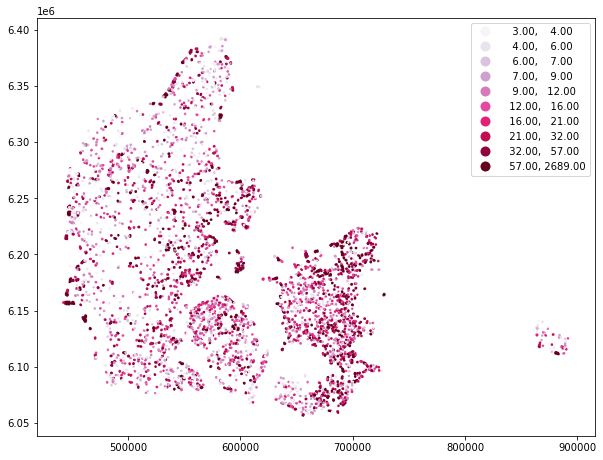

In [13]:
ax = nostops.plot(
    column='population',
    scheme='quantiles',
    legend=True,
    figsize=(10,10),
    k=10,
    cmap='PuRd'

)

Using the function generate_points_in_polygon we wrote in the Public Transit notebook, we can generate point patterns representing every person in settlements (assuming somewhat normal population distribution within boundaries.
This can be used to create point pattern analysis.
Let's copy it into this project:

In [14]:
def generate_points_in_polygon(row):
    polygon = row['geometry']
    n = row['population']
    i = 0
    minx, miny, maxx, maxy = polygon.bounds
    ppoints = np.zeros((n, 2), dtype=np.float64)
    prep_poly = prep(polygon)  # speeds up repeated `.contains()` calls

    while i < n:
        # Sample uniformly in bounding box
        random_points = np.column_stack([
            np.random.uniform(minx, maxx, n),
            np.random.uniform(miny, maxy, n)
        ])

        # Filter points inside the polygon
        for x, y in random_points:
            pt = Point(x, y)
            if prep_poly.contains(pt):
                ppoints[i] = ([x, y])
                i += 1
            if i == n:
                break

    return ppoints

First, I am curious of what the absolute population excluded from public transit is.

In [15]:
nostops['population'].sum()

108810

In [16]:
points_a = nostops.apply(generate_points_in_polygon, axis=1)
points_b = nostops.apply(generate_points_in_polygon, axis=1)

In [17]:
longs_a = [x[0] for sublist in points_a for x in sublist]
lats_a = [x[1] for sublist in points_a for x in sublist]

longs_b = [x[0] for sublist in points_a for x in sublist]
lats_b = [x[1] for sublist in points_a for x in sublist]

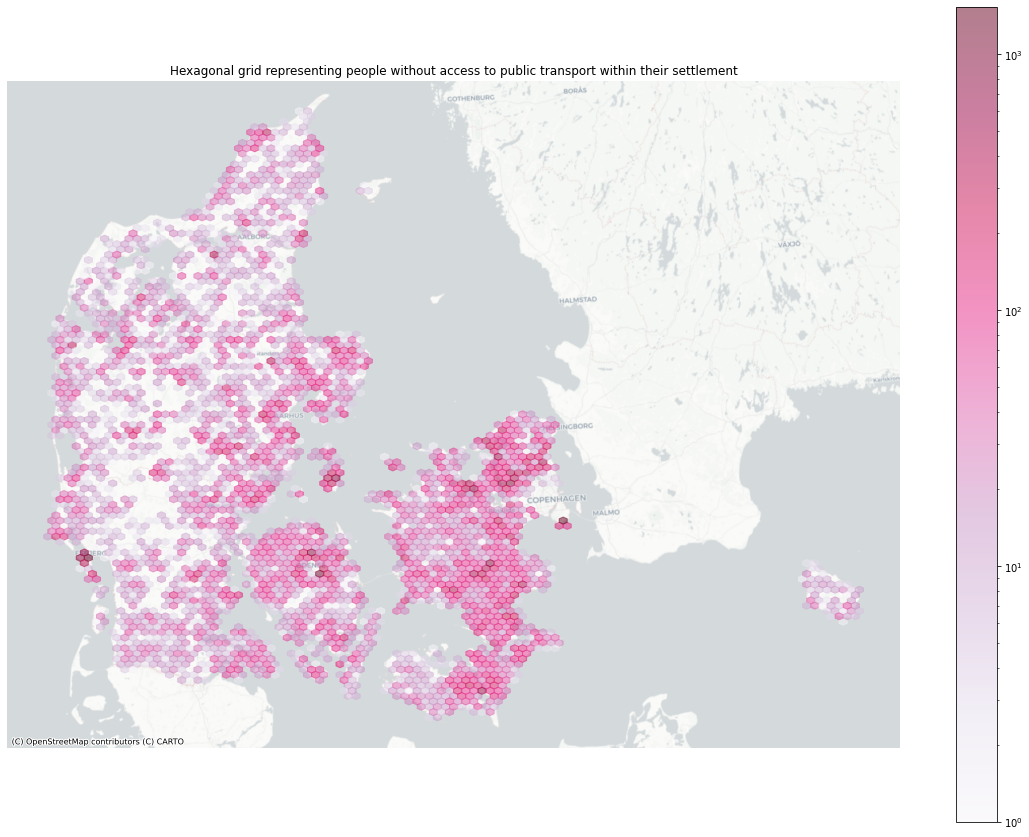

In [18]:
# Setup figure and axis
# f, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 10))
f, ax1 = plt.subplots(1, figsize=(20, 15))
# Add hexagon layer that displays count of points in each polygon
hb = ax1.hexbin(
    longs_a, 
    lats_a, 
    gridsize=100,
    mincnt=1,
    bins='log',
    alpha=0.5,
    cmap='PuRd'
)
ax1.set_title("Hexagonal grid representing people without access to public transport within their settlement")
"""
# Add hexagon layer that displays count of points in each polygon
hb = ax2.hexbin(
    longs_b, 
    lats_b, 
    gridsize=100,
    mincnt=1,
    bins='log',
    alpha=0.5,
    cmap='PuRd'
)
ax2.set_axis_off()
ax2.set_title("Hexagonal grid representing people without access to public transport within walking distance of their settlement")

"""
# Add a colorbar (optional)
plt.colorbar(hb);
ax1.set_axis_off()
cx.add_basemap(
    ax1, 
    crs=stops.crs,
    source=cx.providers.CartoDB.Positron
)

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


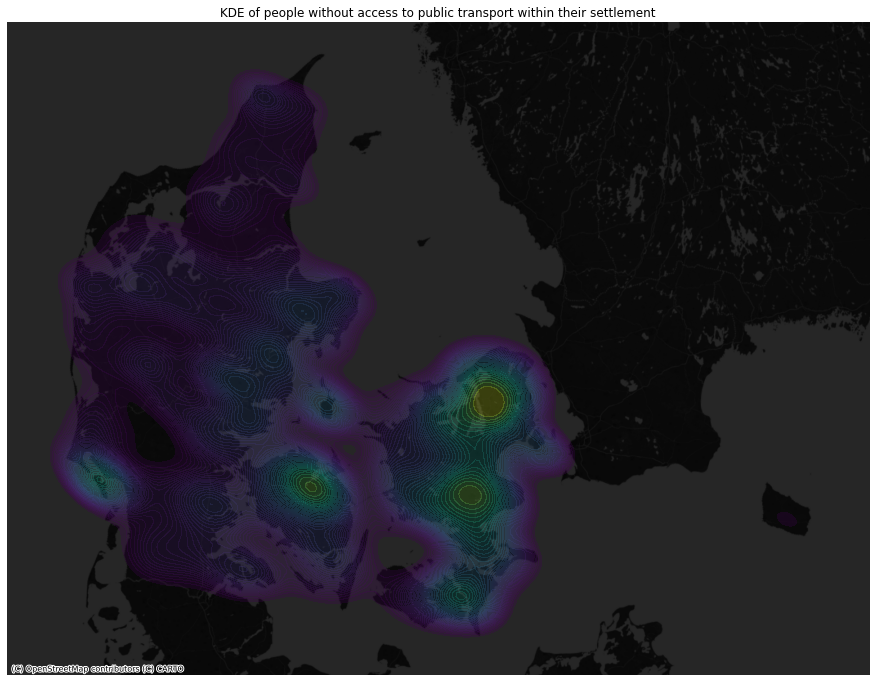

In [19]:

# Setup figure and axis
#f, (ax1,ax2) = plt.subplots(1,2, figsize=(24, 12))
f, ax1 = plt.subplots(1, figsize=(24, 12))
# Add KDE layer that displays probability surface
sns.kdeplot(
    longs_a, 
    lats_a,  
    n_levels=50, 
    shade=True,
    alpha=0.25,
    cmap="viridis",
    ax=ax1
)
# Remove axis
ax1.set_axis_off()
# Add basemap
cx.add_basemap(
    ax1, 
    crs=stops.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Add title of the map
ax1.set_title("KDE of people without access to public transport within their settlement")
"""
# This is extremely similar to the above
# Add KDE layer that displays probability surface
sns.kdeplot(
    longs_b, 
    lats_b,  
    n_levels=50, 
    shade=True,
    alpha=0.25,
    cmap="viridis",
    ax=ax2
)
# Remove axis
ax2.set_axis_off()
# Add basemap
cx.add_basemap(
    ax2, 
    crs=stops.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)
# Add title of the map
ax2.set_title("KDE of people without access to public transport within walking distance of their settlement")
"""
# Draw map
plt.show()

### Spatial weights

From initial exploration in this section, I conclude that there doesn not seem to be a strong and interesting correlation between public transit stop density and other variables of settlements.

In [20]:
sns.pairplot(settlements_stopscount[['nearby_stops', 'population', 'density', 'stop_density']], kind='reg', diag_kind='hist');

NameError: name 'settlements_stopscount' is not defined

In [ ]:
w = weights.distance.DistanceBand.from_dataframe(settlements_stopscount, 10000)

Are the number of nearby stops spatially correlated?

In [ ]:
mi = esda.Moran(settlements_stopscount['nearby_stops'], w)

In [ ]:
mi.I

In [ ]:
mi.p_sim

In [ ]:
plot_moran(mi);